# Notebook overview

The objective of this notebook, is to learn how to transform a time-series problem (demand forecasting) into a tabular one.

For this we will use the M5 competition dataset, large and popular dataset.

In [1]:
!pip install dask[dataframe] eccd_datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 8.2 MB/s eta 0:00:00


In [22]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from eccd_datasets import load_m5
from sklearn.metrics import root_mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Preparing the dataset

Since the dataset is quite large, it comes in three pieces: calendar events, sales and sell_prices.

In [3]:
datasets = load_m5()
datasets.keys()

dict_keys(['calendar', 'sales', 'sell_prices'])

In [4]:
df_calendar = datasets["calendar"]
df_calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1


In [5]:
df_sales = datasets["sales"]
df_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [6]:
df_prices = datasets["sell_prices"]
df_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [7]:
def get_data_from_id(id_: str, sales: pd.DataFrame, prices: pd.DataFrame, calendar: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts the dataframe associated with a single item id in long format.
    """

    df = sales[sales["id"] == id_].drop(columns=["id"])
    df = pd.melt(
        df,
        id_vars=[
            "item_id", "dept_id", "cat_id", "store_id", "state_id"],
        var_name = "d",
        value_name = "units_sold"

    )

    df = df.merge(calendar, on="d", how="left")
    df = df.merge(prices, on=["item_id", "store_id", "wm_yr_wk"], how="left")
    df["date"] = pd.to_datetime(df["date"])

    return df


In [8]:
ID = "HOBBIES_1_001_CA_1_validation"
df_id = get_data_from_id(ID, df_sales, df_prices, df_calendar)
print(df_id.shape)
df_id.head()

(1913, 21)


,item_id,dept_id,cat_id,store_id,state_id,d,units_sold,date,wm_yr_wk,weekday,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,2011,None,None,None,None,0,0,0,NaN
1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,...,1,2011,None,None,None,None,0,0,0,NaN
2,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0,2011-01-31,11101,Monday,...,1,2011,None,None,None,None,0,0,0,NaN
3,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0,2011-02-01,11101,Tuesday,...,2,2011,None,None,None,None,1,1,0,NaN
4,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0,2011-02-02,11101,Wednesday,...,2,2011,None,None,None,None,1,0,1,NaN


Text(0, 0.5, '# Units sold')

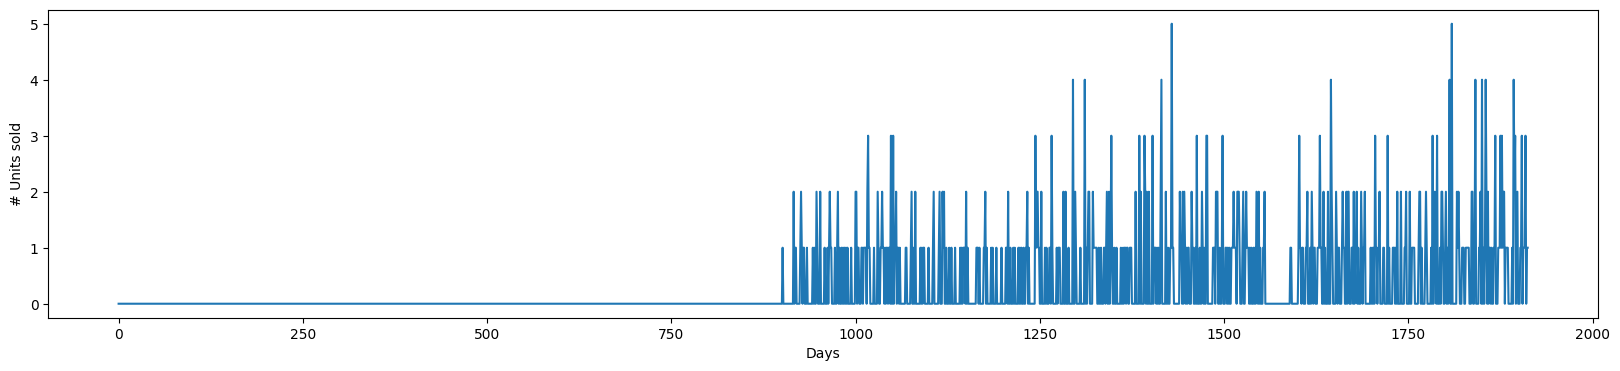

In [9]:
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(df_id["units_sold"])
ax.set_xlabel("Days")
ax.set_ylabel("# Units sold")

We can drop all the attributes that describe the price but don't change across rows since they will not provide useful informaton for training a model.

Furthermore, there are many attributes that are redundant and can be removed.

In [10]:
df_id = df_id.drop(columns=[
    "item_id", "dept_id", "state_id", "cat_id", "store_id", "d", "wm_yr_wk",
    "weekday", "month", "year", "wday"
])
df_id.head()

,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,0,2011-01-29,None,None,None,None,0,0,0,NaN
1,0,2011-01-30,None,None,None,None,0,0,0,NaN
2,0,2011-01-31,None,None,None,None,0,0,0,NaN
3,0,2011-02-01,None,None,None,None,1,1,0,NaN
4,0,2011-02-02,None,None,None,None,1,0,1,NaN


We observe that for some events we don't have a price. We can assume that in those cases, the price is equal to the oldest price available.

In [11]:
df_id["sell_price"] = df_id["sell_price"].bfill()

In [12]:
df_id.head()

,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,0,2011-01-29,None,None,None,None,0,0,0,9.58
1,0,2011-01-30,None,None,None,None,0,0,0,9.58
2,0,2011-01-31,None,None,None,None,0,0,0,9.58
3,0,2011-02-01,None,None,None,None,1,1,0,9.58
4,0,2011-02-02,None,None,None,None,1,0,1,9.58


Implement a function call build_temporal_features that takes `date_variable` which should be a pandas datetype and a `target` wich should be the column name to forecast to create creates several temporal features from it.
    
In particular, it should create the additional columns in the dataframe

Asume that all variables are in the range [0, x])

* `day_of_month` (0 - 30) -> **Assumen that all month has 31 days and the number of the first day is 0**
* `month` (Jan = 0)
* `day_of_week` (Monday=0, Sunday= 6)
* `day_of_week_sin`
* `day_of_week_cos`
* `month_cos`
* `month_sin`
* `day_of_month_sin`
* `day_of_month_cos`
* `lag_1`
* `lag_7`

Remember to sort the dataframe using the data varaible with the most
recent values in the bottom.

In [38]:
def build_temporal_features(date_variable: str, target: str, df: pd.DataFrame) -> pd.DataFrame:
    # Transformo la columna fecha a tipo datetime
    df[date_variable] = pd.to_datetime(df[date_variable])

    # Ordeno el DataFrame por la fecha en forma ascendente
    df = df.sort_values(by=date_variable)

    # Creo características temporales
    df['day_of_month'] = df[date_variable].dt.day -1   # Dia del mes comenzando en 0
    df['month'] = df[date_variable].dt.month - 1       # Mes comenzando en 0 (Enero)
    df['day_of_week'] = df[date_variable].dt.dayofweek # Día de la semana (Lunes es 0 y Domingo es 6)

    # Creo características trigonométricas
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    df['day_of_month_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
    df['day_of_month_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)

    # Creo características de lags
    df['lag_1'] = df[target].shift(1)
    df['lag_7'] = df[target].shift(7)

    return df

In [39]:
df = build_temporal_features("date", "units_sold", df_id)

In [40]:
df.head()

,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,...,month,day_of_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_month_sin,day_of_month_cos,lag_1,lag_7
0,0,2011-01-29,None,None,None,None,0,0,0,9.58,...,0,5,-0.974928,-0.222521,0.0,1.000000,-0.571268,0.820763,NaN,NaN
1,0,2011-01-30,None,None,None,None,0,0,0,9.58,...,0,6,-0.781831,0.623490,0.0,1.000000,-0.394356,0.918958,0.0,NaN
2,0,2011-01-31,None,None,None,None,0,0,0,9.58,...,0,0,0.000000,1.000000,0.0,1.000000,-0.201299,0.979530,0.0,NaN
3,0,2011-02-01,None,None,None,None,1,1,0,9.58,...,1,1,0.781831,0.623490,0.5,0.866025,0.000000,1.000000,0.0,NaN
4,0,2011-02-02,None,None,None,None,1,0,1,9.58,...,1,2,0.974928,-0.222521,0.5,0.866025,0.201299,0.979530,0.0,NaN


In [41]:
df.tail()

,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,...,month,day_of_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_month_sin,day_of_month_cos,lag_1,lag_7
1908,1,2016-04-20,None,None,None,None,0,0,0,8.38,...,3,2,0.974928,-0.222521,1.0,6.123234e-17,-0.651372,-0.758758,1.0,0.0
1909,3,2016-04-21,None,None,None,None,0,0,0,8.38,...,3,3,0.433884,-0.900969,1.0,6.123234e-17,-0.790776,-0.612106,1.0,1.0
1910,0,2016-04-22,None,None,None,None,0,0,0,8.38,...,3,4,-0.433884,-0.900969,1.0,6.123234e-17,-0.897805,-0.440394,3.0,1.0
1911,1,2016-04-23,None,None,None,None,0,0,0,8.38,...,3,5,-0.974928,-0.222521,1.0,6.123234e-17,-0.968077,-0.250653,0.0,3.0
1912,1,2016-04-24,None,None,None,None,0,0,0,8.38,...,3,6,-0.781831,0.623490,1.0,6.123234e-17,-0.998717,-0.050649,1.0,0.0


In [42]:
row = df.iloc[1019]
assert np.allclose(row["day_of_week"], 2)
assert np.allclose(row["day_of_month"], 12)
assert np.allclose(row["month_sin"], -0.866025)
assert np.allclose(row["month_cos"], 0.5)
assert np.allclose(row["day_of_week_sin"], 0.974928)
assert np.allclose(row["day_of_week_cos"], -0.222521)
assert np.allclose(row["day_of_month_cos"], -0.758758)
assert np.allclose(row["lag_1"], 1)

answer_month = row["month"]
answer_month_sin = row["day_of_month_sin"]
answer_lag7 = row["lag_7"]

print(answer_month)
print(answer_month_sin)
print(answer_lag7)

10
0.6513724827222223
1.0


# Splitting the dataset

Unlike normal problems with tabular data, we can't randomly split the data (since each row has a temporal component).

For this we will manually split the dataset and keep the last 30 as test data.

In [43]:
y = df.pop("units_sold")
X = df.copy()

In [44]:
X_train, y_train = X.iloc[:-30], y.iloc[:-30]
X_test, y_test = X.iloc[-30:], y.iloc[-30:]

In [45]:
X_train.shape, y_train.shape

((1883, 20), (1883,))

In [46]:
X_test.shape, y_test.shape

((30, 20), (30,))

# Training with a simple AR model

In [47]:
arima = ARIMA(y_train, order=(7, 1, 0))
arima_res = arima.fit()

In [48]:
y_pred = arima_res.forecast(steps=30)
y_pred.head()

,predicted_mean
1883,1.568404
1884,1.487841
1885,1.610253
1886,1.349949
1887,1.329466


In [49]:
root_mean_squared_error(y_pred, y_test.values)

1.1445853702718816

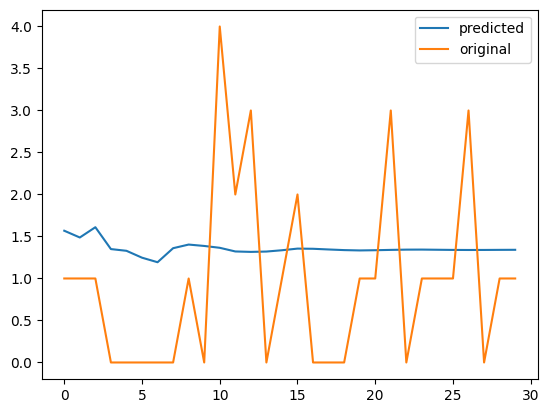

In [50]:
fig, ax = plt.subplots()
ax.plot(y_pred.values, label="predicted")
ax.plot(y_test.values, label="original")
ax.legend()

# Training using ML with Tabular Data

For simplicity we are going to use only the numerical features, without trying to properly encode the other ones.

In [51]:
params = {
    'max_depth': 4,
    'learning_rate': 0.01,
    'n_estimators': 450,
    'boosting_type': 'gbdt',
    'seed': 200,
    'num_threads': 1
}

model = lgb.LGBMRegressor(**params)

model.fit(X_train.select_dtypes(include=["float", "int"]), y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 161
[LightGBM] [Info] Number of data points in the train set: 1883, number of used features: 15
[LightGBM] [Info] Start training from score 0.303240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LGBMRegressor(learning_rate=0.01, max_depth=4, n_estimators=450, num_threads=1,
              seed=200)

In [52]:
y_pred = model.predict(X_test.select_dtypes(include=["float", "int"]))

In [53]:
root_mean_squared_error(y_pred, y_test.values)

1.1676481400878107

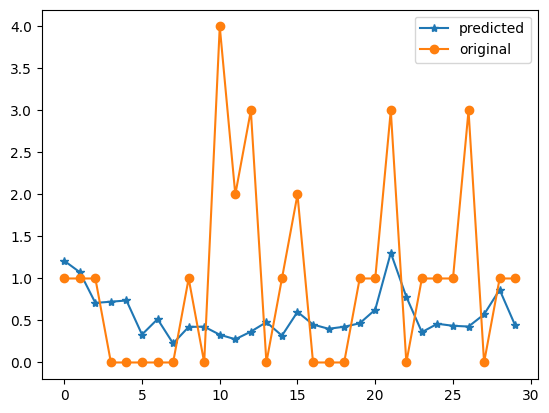

In [54]:
fig, ax = plt.subplots()
ax.plot(y_pred, label="predicted", marker="*")
ax.plot(y_test.values, label="original", marker="o")
ax.legend()

# Summary

We showed how we can build a tabular dataset from a time-series and how we can use traditional techniques such as `Regression Trees` to train such model.

In this example our analysis was quite basic and we kept only a minium number of variables.

Furthermore, an approach that was not explored is to train several items at the same (which requires more computing power), which can further incrase the performance of the model.